# Credit Risk Resampling Techniques

In [1]:
import warnings
warnings.filterwarnings('ignore')

In [2]:
import numpy as np
import pandas as pd
from pathlib import Path
from collections import Counter

In [3]:
from sklearn.metrics import balanced_accuracy_score
from sklearn.metrics import ConfusionMatrixDisplay

# Read the CSV and Perform Basic Data Cleaning

In [4]:
columns = [
    "loan_amnt", "int_rate", "installment", "home_ownership",
    "annual_inc", "verification_status", "issue_d", "loan_status",
    "pymnt_plan", "dti", "delinq_2yrs", "inq_last_6mths",
    "open_acc", "pub_rec", "revol_bal", "total_acc",
    "initial_list_status", "out_prncp", "out_prncp_inv", "total_pymnt",
    "total_pymnt_inv", "total_rec_prncp", "total_rec_int", "total_rec_late_fee",
    "recoveries", "collection_recovery_fee", "last_pymnt_amnt", "next_pymnt_d",
    "collections_12_mths_ex_med", "policy_code", "application_type", "acc_now_delinq",
    "tot_coll_amt", "tot_cur_bal", "open_acc_6m", "open_act_il",
    "open_il_12m", "open_il_24m", "mths_since_rcnt_il", "total_bal_il",
    "il_util", "open_rv_12m", "open_rv_24m", "max_bal_bc",
    "all_util", "total_rev_hi_lim", "inq_fi", "total_cu_tl",
    "inq_last_12m", "acc_open_past_24mths", "avg_cur_bal", "bc_open_to_buy",
    "bc_util", "chargeoff_within_12_mths", "delinq_amnt", "mo_sin_old_il_acct",
    "mo_sin_old_rev_tl_op", "mo_sin_rcnt_rev_tl_op", "mo_sin_rcnt_tl", "mort_acc",
    "mths_since_recent_bc", "mths_since_recent_inq", "num_accts_ever_120_pd", "num_actv_bc_tl",
    "num_actv_rev_tl", "num_bc_sats", "num_bc_tl", "num_il_tl",
    "num_op_rev_tl", "num_rev_accts", "num_rev_tl_bal_gt_0",
    "num_sats", "num_tl_120dpd_2m", "num_tl_30dpd", "num_tl_90g_dpd_24m",
    "num_tl_op_past_12m", "pct_tl_nvr_dlq", "percent_bc_gt_75", "pub_rec_bankruptcies",
    "tax_liens", "tot_hi_cred_lim", "total_bal_ex_mort", "total_bc_limit",
    "total_il_high_credit_limit", "hardship_flag", "debt_settlement_flag"
]

target = ["loan_status"]

In [5]:
len(columns)

86

In [6]:
# Load the data
file_path = Path('LoanStats_2019Q1.csv')
df = pd.read_csv(file_path, skiprows=1)[:-2]
df = df.loc[:, columns].copy()

# Drop the null columns where all values are null
df = df.dropna(axis='columns', how='all')

# Drop the null rows
df = df.dropna()

# Remove the `Issued` loan status
issued_mask = df['loan_status'] != 'Issued'
df = df.loc[issued_mask]

# convert interest rate to numerical
df['int_rate'] = df['int_rate'].str.replace('%', '')
df['int_rate'] = df['int_rate'].astype('float') / 100


# Convert the target column values to low_risk and high_risk based on their values
x = {'Current': 'low_risk'}   
df = df.replace(x)

x = dict.fromkeys(['Late (31-120 days)', 'Late (16-30 days)', 'Default', 'In Grace Period'], 'high_risk')    
df = df.replace(x)

df.reset_index(inplace=True, drop=True)

df.head()

,loan_amnt,int_rate,installment,home_ownership,annual_inc,verification_status,issue_d,loan_status,pymnt_plan,dti,...,pct_tl_nvr_dlq,percent_bc_gt_75,pub_rec_bankruptcies,tax_liens,tot_hi_cred_lim,total_bal_ex_mort,total_bc_limit,total_il_high_credit_limit,hardship_flag,debt_settlement_flag
0,10500.0,0.1719,375.35,RENT,66000.0,Source Verified,Mar-2019,low_risk,n,27.24,...,85.7,100.0,0.0,0.0,65687.0,38199.0,2000.0,61987.0,N,N
1,25000.0,0.2000,929.09,MORTGAGE,105000.0,Verified,Mar-2019,low_risk,n,20.23,...,91.2,50.0,1.0,0.0,271427.0,60641.0,41200.0,49197.0,N,N
2,20000.0,0.2000,529.88,MORTGAGE,56000.0,Verified,Mar-2019,low_risk,n,24.26,...,66.7,50.0,0.0,0.0,60644.0,45684.0,7500.0,43144.0,N,N
3,10000.0,0.1640,353.55,RENT,92000.0,Verified,Mar-2019,low_risk,n,31.44,...,100.0,50.0,1.0,0.0,99506.0,68784.0,19700.0,76506.0,N,N
4,22000.0,0.1474,520.39,MORTGAGE,52000.0,Not Verified,Mar-2019,low_risk,n,18.76,...,100.0,0.0,0.0,0.0,219750.0,25919.0,27600.0,20000.0,N,N


In [7]:
# whar are our categorical value columns
columns_obj = df.select_dtypes(include='object').columns
print(len(columns_obj))

10


In [8]:
# get_dummies method
columns_obj

Index(['home_ownership', 'verification_status', 'issue_d', 'loan_status',
       'pymnt_plan', 'initial_list_status', 'next_pymnt_d', 'application_type',
       'hardship_flag', 'debt_settlement_flag'],
      dtype='object')

In [9]:
# Drop columns with one value in value counts
df = df.drop(columns=['debt_settlement_flag', 'hardship_flag', 'pymnt_plan'])

In [10]:
df.shape

(68817, 83)

# Split the Data into Training and Testing

In [11]:
# Create our features
X = df.drop(columns= "loan_status")
X.shape

(68817, 82)

In [12]:
# Create our target
y = df.loc[:,target]
y

,loan_status
0,low_risk
1,low_risk
2,low_risk
3,low_risk
4,low_risk
...,...
68812,low_risk
68813,low_risk
68814,low_risk
68815,low_risk


In [13]:
X.describe()

,loan_amnt,int_rate,installment,annual_inc,dti,delinq_2yrs,inq_last_6mths,open_acc,pub_rec,revol_bal,...,num_tl_90g_dpd_24m,num_tl_op_past_12m,pct_tl_nvr_dlq,percent_bc_gt_75,pub_rec_bankruptcies,tax_liens,tot_hi_cred_lim,total_bal_ex_mort,total_bc_limit,total_il_high_credit_limit
count,68817.000000,68817.000000,68817.000000,6.881700e+04,68817.000000,68817.000000,68817.000000,68817.000000,68817.000000,68817.000000,...,68817.000000,68817.000000,68817.000000,68817.000000,68817.000000,68817.0,6.881700e+04,6.881700e+04,68817.000000,6.881700e+04
mean,16677.594562,0.127718,480.652863,8.821371e+04,21.778153,0.217766,0.497697,12.587340,0.126030,17604.142828,...,0.052138,2.219423,95.057627,30.626217,0.125972,0.0,2.100332e+05,6.133843e+04,29734.128558,5.572240e+04
std,10277.348590,0.048130,288.062432,1.155800e+05,20.199244,0.718367,0.758122,6.022869,0.336797,21835.880400,...,0.390633,1.897432,8.326426,33.631463,0.336732,0.0,1.928088e+05,5.738798e+04,26795.394232,5.095845e+04
min,1000.000000,0.060000,30.890000,4.000000e+01,0.000000,0.000000,0.000000,2.000000,0.000000,0.000000,...,0.000000,0.000000,20.000000,0.000000,0.000000,0.0,3.600000e+03,2.350000e+02,100.000000,1.270000e+02
25%,9000.000000,0.088100,265.730000,5.000000e+04,13.890000,0.000000,0.000000,8.000000,0.000000,6293.000000,...,0.000000,1.000000,93.000000,0.000000,0.000000,0.0,6.697700e+04,2.650300e+04,11600.000000,2.288000e+04
50%,15000.000000,0.118000,404.560000,7.300000e+04,19.760000,0.000000,0.000000,11.000000,0.000000,12068.000000,...,0.000000,2.000000,100.000000,20.000000,0.000000,0.0,1.467100e+05,4.535700e+04,22100.000000,4.200000e+04
75%,24000.000000,0.155700,648.100000,1.040000e+05,26.660000,0.000000,1.000000,16.000000,0.000000,21735.000000,...,0.000000,3.000000,100.000000,50.000000,0.000000,0.0,3.036400e+05,7.657000e+04,39300.000000,7.249900e+04
max,40000.000000,0.308400,1676.230000,8.797500e+06,999.000000,18.000000,5.000000,72.000000,4.000000,587191.000000,...,18.000000,19.000000,100.000000,100.000000,4.000000,0.0,3.292782e+06,1.295455e+06,509400.000000,1.426964e+06


In [14]:
# use get_dummies to transform object dtypes into int
X_encoded = pd.get_dummies(X)
X_encoded.shape

(68817, 92)

In [15]:
X_encoded.describe()

,loan_amnt,int_rate,installment,annual_inc,dti,delinq_2yrs,inq_last_6mths,open_acc,pub_rec,revol_bal,...,verification_status_Verified,issue_d_Feb-2019,issue_d_Jan-2019,issue_d_Mar-2019,initial_list_status_f,initial_list_status_w,next_pymnt_d_Apr-2019,next_pymnt_d_May-2019,application_type_Individual,application_type_Joint App
count,68817.000000,68817.000000,68817.000000,6.881700e+04,68817.000000,68817.000000,68817.000000,68817.000000,68817.000000,68817.000000,...,68817.000000,68817.000000,68817.000000,68817.000000,68817.000000,68817.000000,68817.000000,68817.000000,68817.000000,68817.000000
mean,16677.594562,0.127718,480.652863,8.821371e+04,21.778153,0.217766,0.497697,12.587340,0.126030,17604.142828,...,0.148001,0.371696,0.451066,0.177238,0.123879,0.876121,0.383161,0.616839,0.860340,0.139660
std,10277.348590,0.048130,288.062432,1.155800e+05,20.199244,0.718367,0.758122,6.022869,0.336797,21835.880400,...,0.355104,0.483261,0.497603,0.381873,0.329446,0.329446,0.486161,0.486161,0.346637,0.346637
min,1000.000000,0.060000,30.890000,4.000000e+01,0.000000,0.000000,0.000000,2.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,9000.000000,0.088100,265.730000,5.000000e+04,13.890000,0.000000,0.000000,8.000000,0.000000,6293.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,1.000000,0.000000
50%,15000.000000,0.118000,404.560000,7.300000e+04,19.760000,0.000000,0.000000,11.000000,0.000000,12068.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,1.000000,1.000000,0.000000
75%,24000.000000,0.155700,648.100000,1.040000e+05,26.660000,0.000000,1.000000,16.000000,0.000000,21735.000000,...,0.000000,1.000000,1.000000,0.000000,0.000000,1.000000,1.000000,1.000000,1.000000,0.000000
max,40000.000000,0.308400,1676.230000,8.797500e+06,999.000000,18.000000,5.000000,72.000000,4.000000,587191.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [16]:
# X_endcoded feature matrix
from sklearn.preprocessing import StandardScaler
# data_scaler = StandardScaler()

In [17]:
# fit and transfrom X_encoded
# X_encoded_scaled = data_scaler.fit_transform(X_encoded)
# X_encoded_scaled[:1]


In [18]:
# Check the balance of our target values
y['loan_status'].value_counts()

low_risk     68470
high_risk      347
Name: loan_status, dtype: int64

In [19]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X_encoded, y, random_state = 1)
X_train

,loan_amnt,int_rate,installment,annual_inc,dti,delinq_2yrs,inq_last_6mths,open_acc,pub_rec,revol_bal,...,verification_status_Verified,issue_d_Feb-2019,issue_d_Jan-2019,issue_d_Mar-2019,initial_list_status_f,initial_list_status_w,next_pymnt_d_Apr-2019,next_pymnt_d_May-2019,application_type_Individual,application_type_Joint App
3903,1600.0,0.0881,50.74,35964.0,24.12,0.0,0.0,20.0,0.0,1156.0,...,0,0,0,1,1,0,0,1,1,0
28390,9000.0,0.0756,280.21,41000.0,16.89,1.0,0.0,16.0,0.0,11157.0,...,0,1,0,0,0,1,0,1,1,0
15470,10000.0,0.1033,214.10,112000.0,17.75,0.0,0.0,14.0,0.0,16904.0,...,1,1,0,0,0,1,0,1,1,0
4279,36000.0,0.1033,1167.21,120000.0,19.95,0.0,1.0,13.0,0.0,63248.0,...,0,0,0,1,0,1,0,1,1,0
57514,18000.0,0.0881,570.81,51000.0,19.11,1.0,0.0,16.0,0.0,17586.0,...,1,0,1,0,0,1,0,1,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
49100,8400.0,0.0646,257.30,37992.0,33.16,0.0,0.0,9.0,0.0,7316.0,...,0,0,1,0,0,1,1,0,1,0
20609,30000.0,0.0646,918.93,217000.0,19.56,0.0,2.0,25.0,0.0,142377.0,...,0,1,0,0,0,1,1,0,1,0
21440,20000.0,0.1180,442.88,35000.0,16.19,0.0,0.0,6.0,0.0,273.0,...,0,1,0,0,0,1,1,0,0,1
50057,11625.0,0.1447,273.34,30000.0,18.96,0.0,2.0,10.0,0.0,8237.0,...,0,0,1,0,0,1,1,0,1,0


In [20]:
# Calculate the accuracy score of the model.
# Generate a confusion matrix.
# print classification report
# Print out the imbalanced classification report.

In [21]:
# Instantiate a logistic regression model
from sklearn.linear_model import LogisticRegression
classifier = LogisticRegression(solver='lbfgs', random_state=1)
classifier

LogisticRegression(random_state=1)

In [22]:
# Fit
classifier.fit(X_train, y_train)

LogisticRegression(random_state=1)

In [23]:
#assess
y_pred = classifier.predict(X_test)
y_pred

array(['low_risk', 'low_risk', 'low_risk', ..., 'low_risk', 'low_risk',
       'low_risk'], dtype=object)

In [24]:
# calculate accuracy
from sklearn.metrics import accuracy_score
accuracy_score(y_test, y_pred)

0.9940714908456844

In [25]:
# create a confusion matrix
from sklearn.metrics import confusion_matrix, classification_report
cm = confusion_matrix(y_test, y_pred)
print(cm)

[[    1   100]
 [    2 17102]]


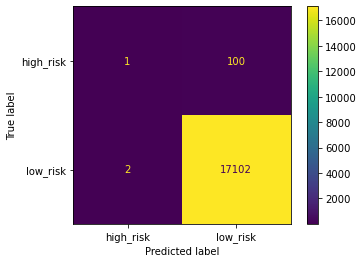

In [26]:
# confusion matrix with ConfusionMatrixDisply
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels= classifier.classes_)
disp.plot()

In [27]:
# view classification report
report = classification_report(y_test, y_pred)
print(report)

              precision    recall  f1-score   support

   high_risk       0.33      0.01      0.02       101
    low_risk       0.99      1.00      1.00     17104

    accuracy                           0.99     17205
   macro avg       0.66      0.50      0.51     17205
weighted avg       0.99      0.99      0.99     17205



# Oversampling

In this section, you will compare two oversampling algorithms to determine which algorithm results in the best performance. You will oversample the data using the naive random oversampling algorithm and the SMOTE algorithm. For each algorithm, be sure to complete the folliowing steps:

1. View the count of the target classes using `Counter` from the collections library. 
3. Use the resampled data to train a logistic regression model.
3. Calculate the balanced accuracy score from sklearn.metrics.
4. Print the confusion matrix from sklearn.metrics.
5. Generate a classication report using the `imbalanced_classification_report` from imbalanced-learn.

Note: Use a random state of 1 for each sampling algorithm to ensure consistency between tests

### Naive Random Oversampling

In [28]:
# import imbalanced-learn dependencies
from imblearn.metrics import classification_report_imbalanced

In [29]:
# Resample the training data with the RandomOversampler
# YOUR CODE HERE
from imblearn.over_sampling import RandomOverSampler
ros = RandomOverSampler(random_state=1)
X_resampled, y_resampled = ros.fit_resample(X_train, y_train)
Counter(y_resampled)

Counter({'loan_status': 1})

In [30]:
# Train the Logistic Regression model using the resampled data
# YOUR CODE HERE
from sklearn.linear_model import LogisticRegression
# model
clf = LogisticRegression(solver='lbfgs', random_state=1)
# fit
clf.fit(X_resampled, y_resampled)
# predict using predict methon
y_pred = clf.predict(X_test)

In [31]:
# Calculated the balanced accuracy score
# YOUR CODE HERE
balanced_accuracy_score(y_test, y_pred)

0.6534714246681919

In [32]:
# Display the confusion matrix
confusion_matrix(y_test, y_pred)

array([[   72,    29],
       [ 6943, 10161]])

In [33]:
# Print the imbalanced classification report
# YOUR CODE HERE
print(classification_report_imbalanced(y_test, y_pred))

                   pre       rec       spe        f1       geo       iba       sup

  high_risk       0.01      0.71      0.59      0.02      0.65      0.43       101
   low_risk       1.00      0.59      0.71      0.74      0.65      0.42     17104

avg / total       0.99      0.59      0.71      0.74      0.65      0.42     17205



### SMOTE Oversampling

In [34]:
# Resample the training data with SMOTE
from imblearn.over_sampling import SMOTE
# YOUR CODE HERE
X_resampled, y_resampled = SMOTE(random_state=1, sampling_strategy='auto').fit_resample(X_train, y_train)
Counter(y_resampled)

Counter({'loan_status': 1})

In [35]:
# model
clf = LogisticRegression(solver='lbfgs', random_state=1)


In [36]:
# Train the Logistic Regression model using the resampled data
# YOUR CODE HERE
clf.fit(X_resampled, y_resampled)

# predict
y_pred = clf.predict(X_test)

In [37]:
# Calculated the balanced accuracy score
# YOUR CODE HERE
balanced_accuracy_score(y_test, y_pred)


0.6362002635015607

In [38]:
# Display the confusion matrix
# YOUR CODE HERE
confusion_matrix(y_test, y_pred)

array([[   61,    40],
       [ 5671, 11433]])

In [39]:
# Print the imbalanced classification report
# YOUR CODE HERE
print(classification_report_imbalanced(y_test, y_pred))

                   pre       rec       spe        f1       geo       iba       sup

  high_risk       0.01      0.60      0.67      0.02      0.64      0.40       101
   low_risk       1.00      0.67      0.60      0.80      0.64      0.41     17104

avg / total       0.99      0.67      0.60      0.80      0.64      0.41     17205



# Undersampling

In this section, you will test an undersampling algorithms to determine which algorithm results in the best performance compared to the oversampling algorithms above. You will undersample the data using the Cluster Centroids algorithm and complete the folliowing steps:

1. View the count of the target classes using `Counter` from the collections library. 
3. Use the resampled data to train a logistic regression model.
3. Calculate the balanced accuracy score from sklearn.metrics.
4. Print the confusion matrix from sklearn.metrics.
5. Generate a classication report using the `imbalanced_classification_report` from imbalanced-learn.

Note: Use a random state of 1 for each sampling algorithm to ensure consistency between tests

In [40]:
# Resample the data using the ClusterCentroids resampler
from imblearn.under_sampling import ClusterCentroids
# Warning: This is a large dataset, and this step may take some time to complete
# YOUR CODE HERE
cc = ClusterCentroids(random_state=1)
X_resampled, y_resampled = cc.fit_resample(X_train, y_train)
Counter(y_resampled)

Counter({'loan_status': 1})

In [41]:
# Train the Logistic Regression model using the resampled data
# YOUR CODE HERE
from sklearn.linear_model import LogisticRegression
clf = LogisticRegression(solver='lbfgs', random_state=1)
clf.fit(X_resampled, y_resampled)

LogisticRegression(random_state=1)

In [42]:
# Calculated the balanced accuracy score
# YOUR CODE HERE
from sklearn.metrics import balanced_accuracy_score
balanced_accuracy_score(y_test, y_pred)

0.6362002635015607

In [43]:
# Display the confusion matrix
# YOUR CODE HERE
y_pred = clf.predict(X_test)
confusion_matrix(y_test, y_pred)

array([[   68,    33],
       [10392,  6712]])

In [44]:
# Print the imbalanced classification report
# YOUR CODE HERE
print(classification_report_imbalanced(y_test, y_pred))

                   pre       rec       spe        f1       geo       iba       sup

  high_risk       0.01      0.67      0.39      0.01      0.51      0.27       101
   low_risk       1.00      0.39      0.67      0.56      0.51      0.26     17104

avg / total       0.99      0.39      0.67      0.56      0.51      0.26     17205



# Combination (Over and Under) Sampling

In this section, you will test a combination over- and under-sampling algorithm to determine if the algorithm results in the best performance compared to the other sampling algorithms above. You will resample the data using the SMOTEENN algorithm and complete the folliowing steps:

1. View the count of the target classes using `Counter` from the collections library. 
3. Use the resampled data to train a logistic regression model.
3. Calculate the balanced accuracy score from sklearn.metrics.
4. Print the confusion matrix from sklearn.metrics.
5. Generate a classication report using the `imbalanced_classification_report` from imbalanced-learn.

Note: Use a random state of 1 for each sampling algorithm to ensure consistency between tests

In [45]:
# Resample the training data with SMOTEENN
# Warning: This is a large dataset, and this step may take some time to complete
# YOUR CODE HERE
from imblearn.combine import SMOTEENN
smote_enn = SMOTEENN(random_state=1)
X_resampled, y_resampled =smote_enn.fit_resample(X_train, y_train)
Counter(y_resampled)



Counter({'loan_status': 1})

In [46]:
# Train the Logistic Regression model using the resampled data
# YOUR CODE HERE
clf = LogisticRegression(solver='lbfgs', random_state=1)
clf.fit(X_resampled, y_resampled)

LogisticRegression(random_state=1)

In [47]:
# Calculated the balanced accuracy score
# YOUR CODE HERE
y_pred = clf.predict(X_test)
balanced_accuracy_score(y_test, y_pred)

0.6539099185877428

In [48]:
# Display the confusion matrix
# YOUR CODE HERE
confusion_matrix(y_test, y_pred)

array([[   72,    29],
       [ 6928, 10176]])

In [49]:
# Print the imbalanced classification report
# YOUR CODE HERE
print(classification_report_imbalanced(y_test, y_pred))

                   pre       rec       spe        f1       geo       iba       sup

  high_risk       0.01      0.71      0.59      0.02      0.65      0.43       101
   low_risk       1.00      0.59      0.71      0.75      0.65      0.42     17104

avg / total       0.99      0.60      0.71      0.74      0.65      0.42     17205

